# Guided Training
- Die letzten beiden Zellen benoetigen ein SimpleElastix-Setup
## Genereller Ablauf:
- Die canonical-VISCERAL Daten werden geladen und einige Hilfsfunktionen fuer das Erstellen der Laplace-(Block-)Matrizen werden definiert.
- Momentan werden bei den Paaren die MR-Bilder als fixed und die CT-Daten als moving angenommen.
- Der LaplaceMultiGrid-Schritt wird fuer die 3 Dimensionen gekoppelt aufgebaut, d.h. mit insgesamt dann 9 Block-Diagonalen im LGS.
- Fuer das guided-Training werden die Segmentierungslabel herangezogen und fuer eine zufaellige (< reg_iter) Anzahl an Schritten das "guided-grid" zurueckgegeben mittels der Funktion "perform_guided_update", welche ebenfalls die Signed Distance Maps (tanh-clipping auf [0,1]) der Fixed-One-Hot und Guided-Warped-Moving-One-Hot liefert. 
- Waehrend des Trainings wird pro Durchgang ein Bildpaar gezogen, einer zufaelligen Anzahl an guided_update Schritten unterzogen und anschließend wird von dort aus mit GradientTracking ein Update-Schritt fuer das displacement-grid berechnet. Je nach Art des Losses, wird das One-Hot-Warped-Mov-Image dieser aktualisierten Transformation unterworfen und mit dem One-Hot-Fixed-Image verglichen oder die jeweiligen Signed-Distance-Transformationen.
- Als Netz wird momentan die angedachte Y-Struktur genutzt, d.h. fix_net/mov_net werden getrennt pro Modalität genutzt und dann anschliessend noch durch das shared-weight "back_net" gefuehrt.
- Das direkte Einbeziehen von MIND-Features als Eingabe im Netz vor lernbaren Layern hat leider ebenso wenig stabile Ergebnisse gebracht bisher, wie das Training von Scratch.
- Der Sinn der einzelnen Zellen wird im Folgenden nochmal detaillierter kommentiert.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import torch.nn.functional as F
import warnings
#warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

flag_all = True

In [2]:
# two Laplace matrix generating functions: 
# the first one is used on the right hand side of the LGS to compute the
# term that is dependend on the previous grid-step (e.g.: - L*u_kminus1)
# the second one generates block-sparse Laplace matrices that will be used during the construction of the 
# LSE lefthand side 

def laplace(lambda_weight,D,H,W):
    # e.g. 3x3: 
    # 0 1 2    -> to get "down" neighbors: take xy[1:,:]  -> 3 4 5 and xy[:-1,:] -> 0 1 2      
    # 3 4 5                                                  6 7 8                  3 4 5
    # 6 7 8
    # i.e.: get index pairs: 3 4 5 6 7 8  
    #                        0 1 2 3 4 5
    # do the same for "up", "left" and "right" neighbors
    xyz = torch.arange(D*H*W).view(D,H,W)
    i1 = torch.cat((xyz[1:,:,:].reshape(1,-1),xyz[:-1,:,:].reshape(1,-1)),0)
    i2 = torch.cat((xyz[:-1,:,:].reshape(1,-1),xyz[1:,:,:].reshape(1,-1)),0)
    i3 = torch.cat((xyz[:,1:,:].reshape(1,-1),xyz[:,:-1,:].reshape(1,-1)),0)
    i4 = torch.cat((xyz[:,:-1,:].reshape(1,-1),xyz[:,1:,:].reshape(1,-1)),0)
    i5 = torch.cat((xyz[:,:,1:].reshape(1,-1),xyz[:,:,:-1].reshape(1,-1)),0)
    i6 = torch.cat((xyz[:,:,:-1].reshape(1,-1),xyz[:,:,1:].reshape(1,-1)),0)
    
    sparse_idx_positions = torch.cat((i1,i2,i3,i4,i5,i6),1)
    
    # now fill a sparse matrix at these indices with -1 * lambda
    A = lambda_weight * torch.sparse.FloatTensor(sparse_idx_positions, # indices 
                                                 -torch.ones(sparse_idx_positions.size(1)), # values to fill in 
                                                 torch.Size([H*W*D,H*W*D])) # output shape
    Di = torch.spmm(A,-torch.ones(H*W*D,1)).view(-1) # compute column sum to add at main diagonal
    Di = torch.sparse.FloatTensor(torch.stack((torch.arange(H*W*D),torch.arange(H*W*D)),0), 
                                  Di, 
                                  torch.Size([H*W*D,H*W*D]))
    L = (Di + A)#.to_dense() 
    return L


def laplace_block(lambda_weight,D,H,W,position):
    # e.g. 3x3: 
    # 0 1 2    -> to get "down" neighbors: take xy[1:,:]  -> 3 4 5 and xy[:-1,:] -> 0 1 2      
    # 3 4 5                                                  6 7 8                  3 4 5
    # 6 7 8
    # i.e.: get index pairs: 3 4 5 6 7 8  
    #                        0 1 2 3 4 5
    # do the same for "up", "left" and "right" neighbors
    xyz = torch.arange(D*H*W).view(D,H,W)
    i1 = torch.cat((xyz[1:,:,:].reshape(1,-1),xyz[:-1,:,:].reshape(1,-1)),0)
    i2 = torch.cat((xyz[:-1,:,:].reshape(1,-1),xyz[1:,:,:].reshape(1,-1)),0)
    i3 = torch.cat((xyz[:,1:,:].reshape(1,-1),xyz[:,:-1,:].reshape(1,-1)),0)
    i4 = torch.cat((xyz[:,:-1,:].reshape(1,-1),xyz[:,1:,:].reshape(1,-1)),0)
    i5 = torch.cat((xyz[:,:,1:].reshape(1,-1),xyz[:,:,:-1].reshape(1,-1)),0)
    i6 = torch.cat((xyz[:,:,:-1].reshape(1,-1),xyz[:,:,1:].reshape(1,-1)),0)
    
    sparse_idx_positions = torch.cat((i1,i2,i3,i4,i5,i6),1)
    
    if 'u' == position:
        # upper left
        # now fill a sparse matrix at these indices with -1 * lambda
        A = lambda_weight * torch.sparse.FloatTensor(sparse_idx_positions, # indices 
                                                     -torch.ones(sparse_idx_positions.size(1)), # values to fill in 
                                                     torch.Size([3*H*W*D,3*H*W*D])) # output shape
        Di = torch.spmm(A,-torch.ones(3*H*W*D,1)).view(-1) # compute column sum to add at main diagonal
        Di = torch.sparse.FloatTensor(torch.stack((torch.arange(3*H*W*D),torch.arange(3*H*W*D)),0), 
                                      Di, 
                                      torch.Size([3*H*W*D,3*H*W*D]))
        L = (Di + A)#.to_dense() 
        return L
    
    if 'm' == position:
        # middle
        # now fill a sparse matrix at these indices with -1 * lambda
        A = lambda_weight * torch.sparse.FloatTensor(sparse_idx_positions + (H*W*D), # indices 
                                                     -torch.ones(sparse_idx_positions.size(1)), # values to fill in 
                                                     torch.Size([3*H*W*D,3*H*W*D])) # output shape
        Di = torch.spmm(A,-torch.ones(3*H*W*D,1)).view(-1) # compute column sum to add at main diagonal
        Di = torch.sparse.FloatTensor(torch.stack((torch.arange(3*H*W*D),torch.arange(3*H*W*D)),0), 
                                      Di, 
                                      torch.Size([3*H*W*D,3*H*W*D]))
        L = (Di + A)#.to_dense() 
        return L
    
    if 'l' == position:
        # lower right
        # now fill a sparse matrix at these indices with -1 * lambda
        A = lambda_weight * torch.sparse.FloatTensor(sparse_idx_positions + (2*H*W*D), # indices 
                                                     -torch.ones(sparse_idx_positions.size(1)), # values to fill in 
                                                     torch.Size([3*H*W*D,3*H*W*D])) # output shape
        Di = torch.spmm(A,-torch.ones(3*H*W*D,1)).view(-1) # compute column sum to add at main diagonal
        Di = torch.sparse.FloatTensor(torch.stack((torch.arange(3*H*W*D),torch.arange(3*H*W*D)),0), 
                                      Di, 
                                      torch.Size([3*H*W*D,3*H*W*D]))
        L = (Di + A)#.to_dense() 
        return L

In [3]:
# this function is used to load & preprocess a CT-MR-image pair

def get_ct_mr_pair(ct_idx, mr_idx, scale_factor):
    
    ct_base_path = '/share/data_sam1/blendowski/no_backup/tmp/imagedata/VISCERAL_canonical/'
    mr_base_path = '/share/data_sam1/blendowski/no_backup/tmp/imagedata/VISCERAL_canonical/'

    # fix MR, mov CT
    ct_pat = ct_idx.__str__()
    mr_pat = mr_idx.__str__()

    print('CT Pat: ', ct_pat, ' :: MR Pat: ', mr_pat)
    img_mov = nib.load(ct_base_path+'ct'+ct_pat+'_img.nii.gz').get_data()
    img_mov = torch.from_numpy(img_mov).float().unsqueeze(0).unsqueeze(0)

    seg_mov = nib.load(ct_base_path+'ct'+ct_pat+'_seg.nii.gz').get_data()
    seg_mov = torch.from_numpy(seg_mov).float().unsqueeze(0).unsqueeze(0)

    img_fix = nib.load(ct_base_path+'mr'+mr_pat+'_img.nii.gz').get_data()
    img_fix = torch.from_numpy(img_fix).float().unsqueeze(0).unsqueeze(0)

    seg_fix = nib.load(ct_base_path+'mr'+mr_pat+'_seg.nii.gz').get_data()
    seg_fix = torch.from_numpy(seg_fix).float().unsqueeze(0).unsqueeze(0)

    _,_,D_,H_,W_ = img_mov.size()




    sc_val = scale_factor
    sc_size = (int(sc_val*D_),int(sc_val*H_),int(sc_val*W_))

    #print('Original Size: ',D_,H_,W_)
    #print('Rescaled Size: ',sc_size, ' factor: ', sc_val.__str__())
    #print('Dice base:' ,dice_coeff(seg_mov,seg_fix,max_label=8),dice_coeff(seg_mov,seg_fix,max_label=8).mean())

    img_mov = torch.nn.functional.interpolate(img_mov,size=sc_size)
    seg_mov = torch.nn.functional.interpolate(seg_mov,size=sc_size,mode='nearest')
    img_fix = torch.nn.functional.interpolate(img_fix,size=sc_size)
    seg_fix = torch.nn.functional.interpolate(seg_fix,size=sc_size,mode='nearest')

    # preprocess with a zero-mean 1-std-dev trafo below?
    
    img_mov -= img_mov.mean()
    img_mov /= img_mov.std()
    img_mov /= torch.abs(img_mov).max()
    img_fix -= img_fix.mean()
    img_fix /= img_fix.std()
    img_fix /= torch.abs(img_fix).max()

    return img_fix, seg_fix, img_mov, seg_mov

In [4]:
# build derivatives: these will be employed during the building of the LSE  

def d_dW(img_in): # D
    b,c,d,h,w = img_in.size()
    kernel = torch.zeros(c,1,3,3,3)
    kernel[:,0,1,1,0] = -0.5
    kernel[:,0,1,1,2] = +0.5
    kernel = kernel.to(img_in.device)
    out = torch.nn.functional.conv3d(img_in, kernel, bias=None, stride=1, padding=0, dilation=1, groups=c)
    out = torch.nn.functional.pad(out,(1,1,1,1,1,1),mode='replicate')
    return out


def d_dH(img_in):
    b,c,d,h,w = img_in.size()
    kernel = torch.zeros(c,1,3,3,3)
    kernel[:,0,1,0,1] = -0.5
    kernel[:,0,1,2,1] = +0.5
    kernel = kernel.to(img_in.device)
    out = torch.nn.functional.conv3d(img_in, kernel, bias=None, stride=1, padding=0, dilation=1, groups=c)
    out = torch.nn.functional.pad(out,(1,1,1,1,1,1),mode='replicate')
    return out

def d_dD(img_in): # W
    b,c,d,h,w = img_in.size()
    kernel = torch.zeros(c,1,3,3,3)
    kernel[:,0,0,1,1] = -0.5
    kernel[:,0,2,1,1] = +0.5
    kernel = kernel.to(img_in.device)
    out = torch.nn.functional.conv3d(img_in, kernel, bias=None, stride=1, padding=0, dilation=1, groups=c)
    out = torch.nn.functional.pad(out,(1,1,1,1,1,1),mode='replicate')
    return out

In [5]:
# differentiable solver to propagate the gradient towards the difference-image representations on the RHS of the LSE
from scipy.sparse import csr_matrix
import pyamg

class MySparseSolverFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, A,b,iters):
        
        A_ind = A._indices().cpu().data.numpy()
        A_val = A._values().cpu().data.numpy()
        n1,n2 = A.size()
        SC = csr_matrix((A_val,(A_ind[0,:],A_ind[1,:])), shape=(n1,n2))
        ml = pyamg.ruge_stuben_solver(SC,max_levels=10)                    # construct the multigrid hierarchy
        #print(ml)                                                        # print hierarchy information
        b_ = b.cpu().data.numpy()
        x = ml.solve(b_, tol=1e-4)
        x = torch.from_numpy(x).view(-1,1).to(b.device)
        # save all tensors for backward step
        ctx.save_for_backward(A,b,x)
        
        return x

    @staticmethod
    def backward(ctx, grad_output):
        A,b,x = ctx.saved_tensors
        A_ind = A._indices().cpu().data.numpy()
        A_val = A._values().cpu().data.numpy()
        n1,n2 = A.size()
        
        grad_output_ = grad_output.cpu().data.numpy()
        SC_A_transposed = csr_matrix((A_val,(A_ind[1,:],A_ind[0,:])), shape=(n2,n1))
        ml = pyamg.ruge_stuben_solver(SC_A_transposed,max_levels=10)
        grad_b = ml.solve(grad_output_, tol=1e-4)
        grad_b = torch.from_numpy(grad_b).view(-1,1).to(x.device)
        
        A_back_val = (-grad_b[A_ind[0,:]]*x[A_ind[1,:]]).squeeze().to(x.device)
        A_back = torch.sparse.FloatTensor(A._indices(), A_back_val, A.size()).to(x.device)
        return A_back, grad_b, None
    
def mlg_solver(A,b,iters):
    return MySparseSolverFunction.apply(A,b,iters)

In [6]:
def dice_coeff(outputs, labels, max_label):
    """
    Evaluation function for Dice score of segmentation overlap
    """
    dice = torch.FloatTensor(max_label-1).fill_(0).to(outputs.device)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = (iflat * tflat).sum()
        dice[label_num-1] = (2. * intersection) / (iflat.sum() + tflat.sum())
    return dice

def countParameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

#hand-crafted MIND-SSC features
def MINDSSC3d(img,dil=3,patch_rad=3):

    kernel = patch_rad*2+1
    #define start-end locations for self-similarity pattern
    six_neighbour = torch.Tensor([[0,1,1],[1,1,0],[1,0,1],[1,1,2],[2,1,1],[1,2,1]])
    pdist = ((six_neighbour.unsqueeze(1)-six_neighbour.unsqueeze(0))**2).sum(2)
    x,y = torch.meshgrid(torch.arange(6),torch.arange(6))
    mask = ((x>y).view(-1))&(pdist.view(-1)==2)
    idx_shift1 = six_neighbour.long().unsqueeze(1).repeat(1,6,1).view(-1,3)[mask,:]
    idx_shift2 = six_neighbour.long().unsqueeze(0).repeat(6,1,1).view(-1,3)[mask,:]
    mshift1 = torch.zeros(12,1,3,3,3).to(img.device).type(img.dtype)
    mshift1.view(-1)[torch.arange(12)*27+idx_shift1[:,0]*9+idx_shift1[:,1]*3+idx_shift1[:,2]] = 1
    mshift2 = torch.zeros(12,1,3,3,3).to(img.device).type(img.dtype)
    mshift2.view(-1)[torch.arange(12)*27+idx_shift2[:,0]*9+idx_shift2[:,1]*3+idx_shift2[:,2]] = 1
    rpad1 = torch.nn.ReplicationPad3d(dil)
    rpad2 = torch.nn.ReplicationPad3d(patch_rad)
    #compute patch-ssd
    ssd = F.avg_pool3d(rpad2((F.conv3d(rpad1(img),mshift1,dilation=dil)-F.conv3d(rpad1(img),mshift2,dilation=dil))**2),kernel,stride=1)
    #MIND equation
    mind = ssd - torch.min(ssd,1,keepdim=True)[0]
    mind_var = torch.mean(mind,1,keepdim=True)
    mind_var = torch.clamp(mind_var,mind_var.mean()*0.001,mind_var.mean()*1000)
    mind /= mind_var
    mind = torch.exp(-mind)
    #permute to have same ordering as C++ code
    mind = mind[:,torch.Tensor([6,8,1,11,2,10,0,7,9,4,5,3]).long(),:,:,:]
    
    return mind

In [7]:
# PREPARE training and test data splits

with torch.no_grad():
    torch.manual_seed(1909)
    ct_patients = torch.arange(1,21)
    mr_patients = torch.arange(1,21)#cat((torch.arange(1,3),torch.arange(4,20)),0)
    
    total_pat_sz = 20
    train_sz = 14
    test_sz = total_pat_sz - train_sz
    
    rnd_perm = torch.randperm(20)
    ct_train_pats = (ct_patients[rnd_perm])[:train_sz]
    ct_test_pats = (ct_patients[rnd_perm])[train_sz:]
    rnd_perm = torch.randperm(20)
    mr_train_pats = (mr_patients[rnd_perm])[:train_sz]
    mr_test_pats = (mr_patients[rnd_perm])[train_sz:]
    
    print('CT Train: ',ct_train_pats)
    print('CT Test:  ',ct_test_pats)
    print('MR Train: ',mr_train_pats)
    print('MR Test:  ',mr_test_pats)
    
    img_fix, seg_fix, img_mov, seg_mov = get_ct_mr_pair(ct_train_pats[0].item(), mr_train_pats[0].item(), 0.70)
        
    B,C,D,H,W = img_fix.size()

    

CT Train:  tensor([ 9,  8,  1,  5, 14,  7, 20,  4, 16, 11, 18, 15, 10,  6])
CT Test:   tensor([ 2, 19, 13,  3, 17, 12])
MR Train:  tensor([17, 13,  5,  3,  8, 18,  4,  2,  7,  9, 16, 10, 20, 11])
MR Test:   tensor([15, 14,  1,  6, 12, 19])
CT Pat:  9  :: MR Pat:  17


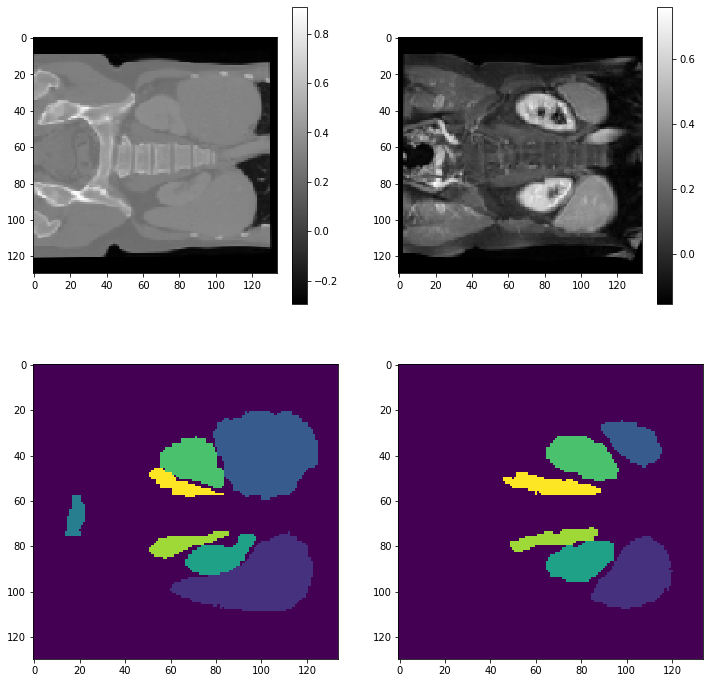

In [8]:
# visualize the first volumes of the training data set
plt.figure(figsize=(12,12))
plt_sl = 35
plt.subplot(221)
plt.imshow(img_mov[0,0,:,plt_sl,:].detach().squeeze(),'gray')
plt.colorbar()
plt.subplot(223)
plt.imshow(seg_mov[0,0,:,plt_sl,:].detach().squeeze())
plt.subplot(222)
plt.imshow(img_fix[0,0,:,plt_sl,:].detach().squeeze(),'gray')
plt.colorbar()
plt.subplot(224)
plt.imshow(seg_fix[0,0,:,plt_sl,:].detach().squeeze())

In [9]:
class MixNet(torch.nn.Module):
    def __init__(self):
        super(MixNet, self).__init__()
        self.c0 = torch.nn.Conv3d(1,16,5,dilation=2,padding=4,stride=1)
        self.c1 = torch.nn.Conv3d(32,32,3,dilation=1,padding=1,stride=2)
        self.c2 = torch.nn.Conv3d(32,32,3,dilation=1,padding=1,stride=1)
        self.c3 = torch.nn.Conv3d(32,12,3,dilation=1,padding=1,stride=1)
        self.n0 = torch.nn.InstanceNorm3d(16)
        self.n1 = torch.nn.InstanceNorm3d(32)
        self.n2 = torch.nn.InstanceNorm3d(32)
        
        self.acti = torch.nn.ReLU()
        self.acti_out = torch.nn.Sigmoid()
        
        self.c0_ct = torch.nn.Conv3d(1,16,5,dilation=2,padding=4,stride=1)
        self.c1_ct = torch.nn.Conv3d(16,32,3,dilation=1,padding=1,stride=1)
        self.c2_ct = torch.nn.Conv3d(32,32,3,dilation=1,padding=1,stride=1)
        self.ct_n0 = torch.nn.InstanceNorm3d(16)
        self.ct_n1 = torch.nn.InstanceNorm3d(32)
        self.ct_n2 = torch.nn.InstanceNorm3d(32)
        
        self.c0_mr = torch.nn.Conv3d(1,16,5,dilation=2,padding=4,stride=1)
        self.c1_mr = torch.nn.Conv3d(16,32,3,dilation=1,padding=1,stride=1)
        self.c2_mr = torch.nn.Conv3d(32,32,3,dilation=1,padding=1,stride=1)
        self.mr_n0 = torch.nn.InstanceNorm3d(16)
        self.mr_n1 = torch.nn.InstanceNorm3d(32)
        self.mr_n2 = torch.nn.InstanceNorm3d(32)
        
        
    def forward(self, x, modality):
        if modality == 'ct':
            x0 = self.acti(self.ct_n0(self.c0_ct(x)))
            x1_s = self.acti(self.ct_n1(self.c1_ct(x0)))
            #x2 = self.acti(self.ct_n2(self.c2_ct(x1)))
            #out = self.acti_out(self.c3(x2))
            #return out
        if modality == 'mr':
            x0 = self.acti(self.mr_n0(self.c0_mr(x)))
            x1_s = self.acti(self.mr_n1(self.c1_mr(x0)))
            #x2 = self.acti(self.mr_n2(self.c2_mr(x1)))
            #out = self.acti_out(self.c3(x2))
            #return out
        x1 = self.acti(self.n1(self.c1(x1_s)))
        x2 = self.acti(self.n2(self.c2(x1)))
        out = self.acti_out(self.c3(x2))
        return out

In [10]:
# generate test pairs that will be used for all three compared methods (SUITS,MIND,SimpleElastix)
with torch.no_grad():
    torch.manual_seed(1909) # BVB!
    # fix MR, mov CT
    
    nr_test_pairs = 25
    
    #build all possible test_combinations
    tpat1_vec = (torch.arange(test_sz)).view(1,-1).repeat(1,test_sz).view(1,-1)
    tpat2_vec = (torch.arange(test_sz)).view(-1,1).repeat(1,test_sz).view(1,-1)
    tpat_pairs = torch.cat((tpat1_vec,tpat2_vec),0)
    tpat_rnd_idx = torch.randperm(tpat_pairs.size(1))[:nr_test_pairs]
    rnd_ct_test = tpat_pairs[0,tpat_rnd_idx]
    rnd_mr_test = tpat_pairs[1,tpat_rnd_idx]   
    
    
    #img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[0].item(), mr_test_pats[0].item(), 0.55)#0.65
    img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[rnd_ct_test[0]].item(), mr_test_pats[rnd_mr_test[0]].item(), 0.70)
    B,C,D,H,W = img_fix_t.size()

CT Pat:  2  :: MR Pat:  1


In [11]:
print(rnd_ct_test)
print(rnd_mr_test)
print(ct_test_pats[rnd_ct_test])
print(mr_test_pats[rnd_mr_test])

tensor([0, 4, 2, 4, 1, 5, 5, 2, 5, 1, 5, 5, 3, 0, 3, 2, 2, 2, 1, 3, 0, 2, 0, 4,
        3])
tensor([2, 5, 2, 2, 2, 1, 3, 1, 0, 4, 4, 2, 1, 4, 3, 4, 0, 3, 1, 0, 1, 5, 5, 3,
        4])
tensor([ 2, 17, 13, 17, 19, 12, 12, 13, 12, 19, 12, 12,  3,  2,  3, 13, 13, 13,
        19,  3,  2, 13,  2, 17,  3])
tensor([ 1, 19,  1,  1,  1, 14,  6, 14, 15, 12, 12,  1, 14, 12,  6, 12, 15,  6,
        14, 15, 14, 19, 19,  6, 12])


In [12]:
mkdir_cmd = 'mkdir ./pretrained_MIND/'
! $mkdir_cmd
mkdir_cmd = 'mkdir ./finetuned_MIND/'
! $mkdir_cmd
mkdir_cmd = 'mkdir ./hand_MIND/'
! $mkdir_cmd
mkdir_cmd = 'mkdir ./simple_elastix/'
! $mkdir_cmd
mkdir_cmd = 'mkdir ./voxelmorph/'
! $mkdir_cmd

1 / 25
CT Pat:  2  :: MR Pat:  1
2 / 25
CT Pat:  17  :: MR Pat:  19
3 / 25
CT Pat:  13  :: MR Pat:  1
4 / 25
CT Pat:  17  :: MR Pat:  1
5 / 25
CT Pat:  19  :: MR Pat:  1
6 / 25
CT Pat:  12  :: MR Pat:  14
7 / 25
CT Pat:  12  :: MR Pat:  6
8 / 25
CT Pat:  13  :: MR Pat:  14
9 / 25
CT Pat:  12  :: MR Pat:  15
10 / 25
CT Pat:  19  :: MR Pat:  12
11 / 25
CT Pat:  12  :: MR Pat:  12
12 / 25
CT Pat:  12  :: MR Pat:  1
13 / 25
CT Pat:  3  :: MR Pat:  14
14 / 25
CT Pat:  2  :: MR Pat:  12
15 / 25
CT Pat:  3  :: MR Pat:  6
16 / 25
CT Pat:  13  :: MR Pat:  12
17 / 25
CT Pat:  13  :: MR Pat:  15
18 / 25
CT Pat:  13  :: MR Pat:  6
19 / 25
CT Pat:  19  :: MR Pat:  14
20 / 25
CT Pat:  3  :: MR Pat:  15
21 / 25
CT Pat:  2  :: MR Pat:  14
22 / 25
CT Pat:  13  :: MR Pat:  19
23 / 25
CT Pat:  2  :: MR Pat:  19
24 / 25
CT Pat:  17  :: MR Pat:  6
25 / 25
CT Pat:  3  :: MR Pat:  12


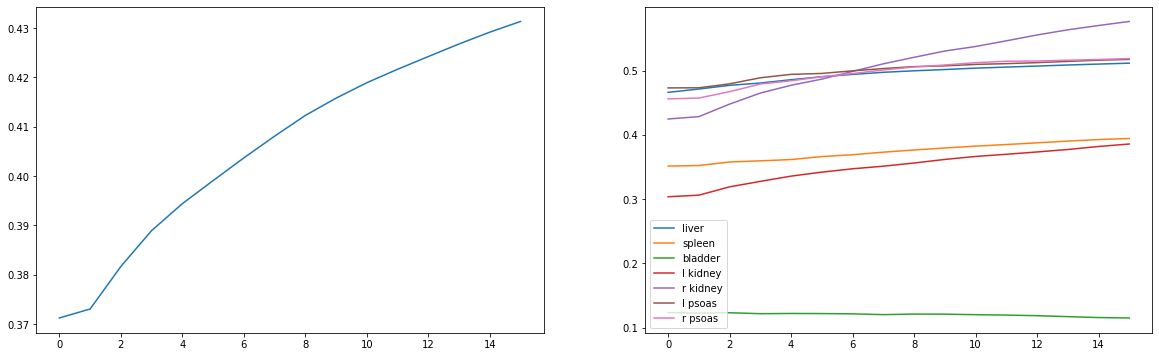

In [13]:
# try to use a MIND_pretrained network...
with torch.no_grad():
    dev_nr = 0
    reg_iter = 15#5
    lambda_reg = 10#50#25
    sc_val = 1.0
    solver_iter = 3
    C_out = 12#8
    
    dice_evo_net_pre = torch.zeros(nr_test_pairs,reg_iter+1,7)
    
    if flag_all:
    
        for tpdx in range(nr_test_pairs):
            print((tpdx+1).__str__()+' / '+nr_test_pairs.__str__())
            # decoupled dimensions
            with torch.cuda.device(dev_nr):
                pre_MINDNet = torch.load('./mind_pretrained_net_70_2layer.pth')
                pre_MINDNet = pre_MINDNet.cuda().eval()

                #img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[tpdx].item(), mr_test_pats[tpdx].item(), 0.55)#0.65
                img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[rnd_ct_test[tpdx]].item(), mr_test_pats[rnd_mr_test[tpdx]].item(), 0.70)
                dice_evo_net_pre[tpdx,0,:] = dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8)

                # get output dimensions!
                test_in = torch.ones(1,1,D,H,W).cuda()
                test_out = pre_MINDNet(test_in,'ct')
                #test_out = back_net(test_in,0.25)
                _,_,Ds,Hs,Ws = test_out.size()

                L = laplace(lambda_reg,Ds,Hs,Ws).cuda()
                L_u = laplace_block(lambda_reg,Ds,Hs,Ws,'u').cuda()
                L_m = laplace_block(lambda_reg,Ds,Hs,Ws,'m').cuda()
                L_l = laplace_block(lambda_reg,Ds,Hs,Ws,'l').cuda()

                u_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
                v_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
                w_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()

                id_grid = torch.nn.functional.affine_grid(torch.eye(3,4).view(1,3,4),(1,1,D,H,W)).cuda()

                avg3d = torch.nn.AvgPool3d(kernel_size=5,padding=2,stride=1)


                for idx in range(reg_iter):

                    # upscale displacement fields
                    with torch.no_grad():
                        grid_up_km1 = torch.cat((w_km1.view(1,Ds,Hs,Ws,1),v_km1.view(1,Ds,Hs,Ws,1),u_km1.view(1,Ds,Hs,Ws,1)),4)
                        grid_up_km1 = avg3d(grid_up_km1.permute(0,4,1,2,3))
                        grid_up_km1 = torch.nn.functional.interpolate(grid_up_km1, size=(D,H,W)).permute(0,2,3,4,1)

                        M_km1_full = torch.nn.functional.grid_sample(img_mov_t.view(1,1,D,H,W).cuda(), 
                                                                     grid_up_km1 + id_grid,
                                                                     padding_mode='border')


                    # generate feature representation
                    M_km1 = pre_MINDNet(M_km1_full.detach(),'ct')
                    fix = pre_MINDNet(img_fix_t.cuda().detach(),'mr')

                    #M_km1 = back_net(M_km1_full.detach(),0.25)
                    #fix = back_net(img_fix.cuda().detach(),0.25)

                    M_km1_dD = d_dD(M_km1)
                    M_km1_dH = d_dH(M_km1)
                    M_km1_dW = d_dW(M_km1)

                    RHS_D = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dD.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,u_km1.view(Ds*Hs*Ws,1))
                    RHS_H = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dH.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,v_km1.view(Ds*Hs*Ws,1))
                    RHS_W = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dW.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,w_km1.view(Ds*Hs*Ws,1))

                    MAT = torch.sparse.FloatTensor(3*Ds*Hs*Ws,3*Ds*Hs*Ws).cuda()

                    M1_DD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dD**2).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_DH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dD*M_km1_dH).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_DW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dD*M_km1_dW).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()

                    M1_HH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dH**2).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_HD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dH*M_km1_dD).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_HW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dH*M_km1_dW).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()

                    M1_WW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dW**2).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_WD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dW*M_km1_dD).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_WH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dW*M_km1_dH).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()


                    MAT = MAT.add(M1_DD).add(L_u)
                    MAT = MAT.add(M1_DH)
                    MAT = MAT.add(M1_DW)

                    MAT = MAT.add(M1_HD)
                    MAT = MAT.add(M1_HH).add(L_m)
                    MAT = MAT.add(M1_HW)

                    MAT = MAT.add(M1_WD)
                    MAT = MAT.add(M1_WH)
                    MAT = MAT.add(M1_WW).add(L_l)

                    RHS = torch.cat((RHS_D, RHS_H, RHS_W),0)

                    wvu = mlg_solver(MAT,RHS,3)

                    w_k = wvu[2*Ds*Hs*Ws:]*(2.0/(Ws-1.0)) 
                    v_k = wvu[Ds*Hs*Ws:2*Ds*Hs*Ws]*(2.0/(Hs-1.0))
                    u_k = wvu[:Ds*Hs*Ws]*(2.0/(Ds-1.0))

                    u_km1_crnt = u_km1 + u_k#*0.05#25
                    v_km1_crnt = v_km1 + v_k#*0.05#25
                    w_km1_crnt = w_km1 + w_k#*0.05#25

                    grid_km1_tmp = torch.cat((w_km1_crnt.view(1,1,Ds,Hs,Ws),
                                              v_km1_crnt.view(1,1,Ds,Hs,Ws),
                                              u_km1_crnt.view(1,1,Ds,Hs,Ws)),1)
                    grid_km1_tmp = avg3d(grid_km1_tmp)
                    grid_km1_tmp = torch.nn.functional.interpolate(grid_km1_tmp, size=(D,H,W),
                                                                   mode='trilinear').permute(0,2,3,4,1)

                    u_km1 = u_km1_crnt.clone().detach()
                    v_km1 = v_km1_crnt.clone().detach()
                    w_km1 = w_km1_crnt.clone().detach()

                    seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                                   grid_km1_tmp + id_grid,
                                                                   mode='nearest',
                                                                   padding_mode='border')
                    dice_evo_net_pre[tpdx,idx+1,:] = dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8)
                
                # save warp seg and image
                ct_pat_str = ct_test_pats[rnd_ct_test[tpdx]].item().__str__()
                mr_pat_str = mr_test_pats[rnd_mr_test[tpdx]].item().__str__()
                seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                               grid_km1_tmp + id_grid,
                                                               mode='nearest',
                                                               padding_mode='border')
                data = seg_mov_warp.squeeze().cpu().numpy()
                new_image = nib.Nifti1Image(data, affine=np.eye(4))
                out_str = './pretrained_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_seg_warp.nii.gz'
                nib.save(new_image,out_str)

                img_mov_warp = torch.nn.functional.grid_sample(img_mov_t.cuda(), 
                                                               grid_km1_tmp + id_grid,
                                                               #mode='bilinear',
                                                               padding_mode='border')
                data = img_mov_warp.squeeze().cpu().numpy()
                new_image = nib.Nifti1Image(data, affine=np.eye(4))
                out_str = './pretrained_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_img_warp.nii.gz'
                nib.save(new_image,out_str)
                
                data = img_fix_t.squeeze().cpu().numpy()
                new_image = nib.Nifti1Image(data, affine=np.eye(4))
                out_str = './pretrained_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_img_fix.nii.gz'
                nib.save(new_image,out_str)
                
                data = seg_fix_t.squeeze().cpu().numpy()
                new_image = nib.Nifti1Image(data, affine=np.eye(4))
                out_str = './pretrained_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_seg_fix.nii.gz'
                nib.save(new_image,out_str)
                
                data = img_mov_t.squeeze().cpu().numpy()
                new_image = nib.Nifti1Image(data, affine=np.eye(4))
                out_str = './pretrained_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_img_mov.nii.gz'
                nib.save(new_image,out_str)
                
                data = seg_mov_t.squeeze().cpu().numpy()
                new_image = nib.Nifti1Image(data, affine=np.eye(4))
                out_str = './pretrained_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_seg_mov.nii.gz'
                nib.save(new_image,out_str)

    plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.plot(dice_evo_net_pre.mean(0).mean(1).cpu().numpy())
    plt.subplot(122)
    plt.plot(dice_evo_net_pre.mean(0).cpu().numpy())
    plt.legend(labels=["liver","spleen","bladder","l kidney","r kidney", "l psoas", "r psoas"])

before:  tensor([0.6758, 0.6241, 0.0000, 0.6948, 0.7423, 0.5189, 0.5185]) tensor(0.5392)
after:  tensor([0.6913, 0.5767, 0.0000, 0.8304, 0.8384, 0.5017, 0.4796]) tensor(0.5597)
torch.Size([1, 12, 65, 48, 67])


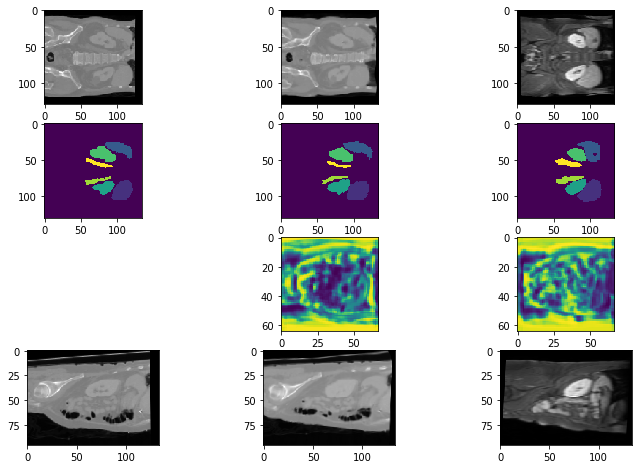

In [14]:
with torch.no_grad():
    if flag_all:
        seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                       grid_km1_tmp + id_grid,
                                                       mode='nearest',
                                                       padding_mode='border')

        print('before: ',dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8),dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8).mean())
        print('after: ',dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8),dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8).mean())


        img_mov_warp = torch.nn.functional.grid_sample(img_mov_t.cuda(), 
                                                       grid_km1_tmp + id_grid,
                                                       #mode='bilinear',
                                                       padding_mode='border')

        print(fix.size())

        plt.figure(figsize=(12,8))
        plt_sl = 35
        plt_slice = 30
        plt_chan = 8
        plt.subplot(4,3,1)
        plt.imshow(img_mov_t.cpu()[0,0,:,plt_sl,:],'gray')
        plt.subplot(4,3,2)
        plt.imshow(img_mov_warp.cpu()[0,0,:,plt_sl,:],'gray')
        plt.subplot(4,3,3)
        plt.imshow(img_fix_t.cpu()[0,0,:,plt_sl,:],'gray')
        plt.subplot(4,3,4)
        plt.imshow(seg_mov_t.cpu()[0,0,:,plt_sl,:])
        plt.subplot(4,3,5)
        plt.imshow(seg_mov_warp.cpu()[0,0,:,plt_sl,:])
        plt.subplot(4,3,6)
        plt.imshow(seg_fix_t.cpu()[0,0,:,plt_sl,:])
        plt.subplot(4,3,8)
        plt.imshow(M_km1.cpu()[0,plt_chan,:,plt_slice,:])
        plt.subplot(4,3,9)
        plt.imshow(fix.cpu()[0,plt_chan,:,plt_slice,:])
        plt.subplot(4,3,10)
        plt.imshow(img_mov_t.cpu()[0,0,40,:,:],'gray')
        plt.subplot(4,3,11)
        plt.imshow(img_mov_warp.cpu()[0,0,40,:,:],'gray')
        plt.subplot(4,3,12)
        plt.imshow(img_fix_t.cpu()[0,0,40,:,:],'gray')

1 / 25
CT Pat:  2  :: MR Pat:  1
2 / 25
CT Pat:  17  :: MR Pat:  19
3 / 25
CT Pat:  13  :: MR Pat:  1
4 / 25
CT Pat:  17  :: MR Pat:  1
5 / 25
CT Pat:  19  :: MR Pat:  1
6 / 25
CT Pat:  12  :: MR Pat:  14
7 / 25
CT Pat:  12  :: MR Pat:  6
8 / 25
CT Pat:  13  :: MR Pat:  14
9 / 25
CT Pat:  12  :: MR Pat:  15
10 / 25
CT Pat:  19  :: MR Pat:  12
11 / 25
CT Pat:  12  :: MR Pat:  12
12 / 25
CT Pat:  12  :: MR Pat:  1
13 / 25
CT Pat:  3  :: MR Pat:  14
14 / 25
CT Pat:  2  :: MR Pat:  12
15 / 25
CT Pat:  3  :: MR Pat:  6
16 / 25
CT Pat:  13  :: MR Pat:  12
17 / 25
CT Pat:  13  :: MR Pat:  15
18 / 25
CT Pat:  13  :: MR Pat:  6
19 / 25
CT Pat:  19  :: MR Pat:  14
20 / 25
CT Pat:  3  :: MR Pat:  15
21 / 25
CT Pat:  2  :: MR Pat:  14
22 / 25
CT Pat:  13  :: MR Pat:  19
23 / 25
CT Pat:  2  :: MR Pat:  19
24 / 25
CT Pat:  17  :: MR Pat:  6
25 / 25
CT Pat:  3  :: MR Pat:  12


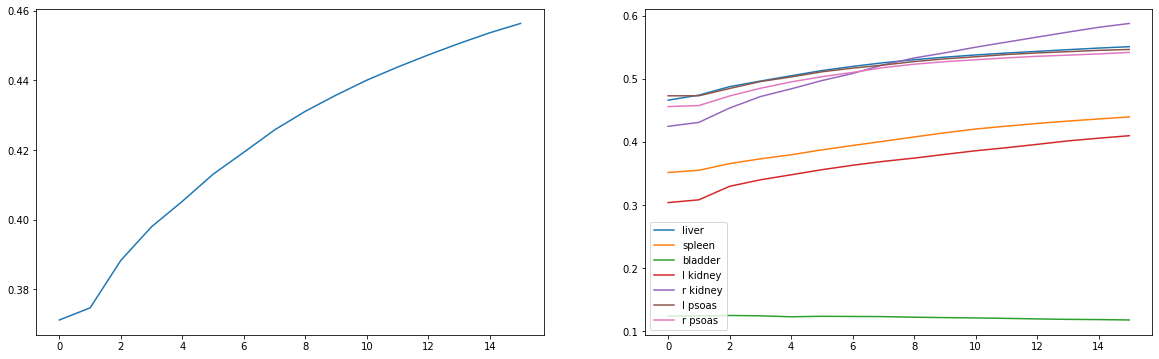

In [15]:
# try to use the fine_tuned MIND network...
with torch.no_grad():
    dev_nr = 0
    reg_iter = 15#5
    lambda_reg = 10#50#25
    sc_val = 1.0
    solver_iter = 3
    C_out = 12#8
    
    dice_evo_net_tune = torch.zeros(nr_test_pairs,reg_iter+1,7)
    
    for tpdx in range(nr_test_pairs):
        print((tpdx+1).__str__()+' / '+nr_test_pairs.__str__())
        # decoupled dimensions
        with torch.cuda.device(dev_nr):
            
            tune_MIND = torch.load('./mind_tuned_net_70_2layer.pth').cuda().eval()
            
            #img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[tpdx].item(), mr_test_pats[tpdx].item(), 0.55)#0.65
            img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[rnd_ct_test[tpdx]].item(), mr_test_pats[rnd_mr_test[tpdx]].item(), 0.70)
            dice_evo_net_tune[tpdx,0,:] = dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8)
            
            # get output dimensions!
            test_in = torch.ones(1,1,D,H,W).cuda()
            test_out = tune_MIND(test_in,'ct')
            #test_out = back_net(test_in,0.25)
            _,_,Ds,Hs,Ws = test_out.size()

            L = laplace(lambda_reg,Ds,Hs,Ws).cuda()
            L_u = laplace_block(lambda_reg,Ds,Hs,Ws,'u').cuda()
            L_m = laplace_block(lambda_reg,Ds,Hs,Ws,'m').cuda()
            L_l = laplace_block(lambda_reg,Ds,Hs,Ws,'l').cuda()

            u_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
            v_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
            w_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()

            id_grid = torch.nn.functional.affine_grid(torch.eye(3,4).view(1,3,4),(1,1,D,H,W)).cuda()

            avg3d = torch.nn.AvgPool3d(kernel_size=5,padding=2,stride=1)


            for idx in range(reg_iter):

                # upscale displacement fields
                with torch.no_grad():
                    grid_up_km1 = torch.cat((w_km1.view(1,Ds,Hs,Ws,1),v_km1.view(1,Ds,Hs,Ws,1),u_km1.view(1,Ds,Hs,Ws,1)),4)
                    grid_up_km1 = avg3d(grid_up_km1.permute(0,4,1,2,3))
                    grid_up_km1 = torch.nn.functional.interpolate(grid_up_km1, size=(D,H,W)).permute(0,2,3,4,1)

                    M_km1_full = torch.nn.functional.grid_sample(img_mov_t.view(1,1,D,H,W).cuda(), 
                                                                 grid_up_km1 + id_grid,
                                                                 padding_mode='border')


                # generate feature representation
                M_km1 = tune_MIND(M_km1_full.detach(),'ct')
                fix = tune_MIND(img_fix_t.cuda().detach(),'mr')

                #M_km1 = back_net(M_km1_full.detach(),0.25)
                #fix = back_net(img_fix.cuda().detach(),0.25)
                
                M_km1_dD = d_dD(M_km1)
                M_km1_dH = d_dH(M_km1)
                M_km1_dW = d_dW(M_km1)

                RHS_D = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dD.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,u_km1.view(Ds*Hs*Ws,1))
                RHS_H = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dH.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,v_km1.view(Ds*Hs*Ws,1))
                RHS_W = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dW.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,w_km1.view(Ds*Hs*Ws,1))

                MAT = torch.sparse.FloatTensor(3*Ds*Hs*Ws,3*Ds*Hs*Ws).cuda()

                M1_DD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dD**2).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                M1_DH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dD*M_km1_dH).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                M1_DW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dD*M_km1_dW).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()

                M1_HH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dH**2).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                M1_HD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dH*M_km1_dD).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                M1_HW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dH*M_km1_dW).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()

                M1_WW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dW**2).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                M1_WD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dW*M_km1_dD).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                M1_WH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dW*M_km1_dH).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()


                MAT = MAT.add(M1_DD).add(L_u)
                MAT = MAT.add(M1_DH)
                MAT = MAT.add(M1_DW)

                MAT = MAT.add(M1_HD)
                MAT = MAT.add(M1_HH).add(L_m)
                MAT = MAT.add(M1_HW)

                MAT = MAT.add(M1_WD)
                MAT = MAT.add(M1_WH)
                MAT = MAT.add(M1_WW).add(L_l)

                RHS = torch.cat((RHS_D, RHS_H, RHS_W),0)

                wvu = mlg_solver(MAT,RHS,3)

                w_k = wvu[2*Ds*Hs*Ws:]*(2.0/(Ws-1.0)) 
                v_k = wvu[Ds*Hs*Ws:2*Ds*Hs*Ws]*(2.0/(Hs-1.0))
                u_k = wvu[:Ds*Hs*Ws]*(2.0/(Ds-1.0))

                u_km1_crnt = u_km1 + u_k#*0.05#25
                v_km1_crnt = v_km1 + v_k#*0.05#25
                w_km1_crnt = w_km1 + w_k#*0.05#25

                grid_km1_tmp = torch.cat((w_km1_crnt.view(1,1,Ds,Hs,Ws),
                                          v_km1_crnt.view(1,1,Ds,Hs,Ws),
                                          u_km1_crnt.view(1,1,Ds,Hs,Ws)),1)
                grid_km1_tmp = avg3d(grid_km1_tmp)
                grid_km1_tmp = torch.nn.functional.interpolate(grid_km1_tmp, size=(D,H,W),
                                                               mode='trilinear').permute(0,2,3,4,1)

                u_km1 = u_km1_crnt.clone().detach()
                v_km1 = v_km1_crnt.clone().detach()
                w_km1 = w_km1_crnt.clone().detach()

                seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                               grid_km1_tmp + id_grid,
                                                               mode='nearest',
                                                               padding_mode='border')
                dice_evo_net_tune[tpdx,idx+1,:] = dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8)
                
            # save warp seg and image
            ct_pat_str = ct_test_pats[rnd_ct_test[tpdx]].item().__str__()
            mr_pat_str = mr_test_pats[rnd_mr_test[tpdx]].item().__str__()
            seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                           grid_km1_tmp + id_grid,
                                                           mode='nearest',
                                                           padding_mode='border')
            data = seg_mov_warp.squeeze().cpu().numpy()
            new_image = nib.Nifti1Image(data, affine=np.eye(4))
            out_str = './finetuned_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_seg_warp.nii.gz'
            nib.save(new_image,out_str)

            img_mov_warp = torch.nn.functional.grid_sample(img_mov_t.cuda(), 
                                                           grid_km1_tmp + id_grid,
                                                           #mode='bilinear',
                                                           padding_mode='border')
            data = img_mov_warp.squeeze().cpu().numpy()
            new_image = nib.Nifti1Image(data, affine=np.eye(4))
            out_str = './finetuned_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_img_warp.nii.gz'
            nib.save(new_image,out_str)

            data = img_fix_t.squeeze().cpu().numpy()
            new_image = nib.Nifti1Image(data, affine=np.eye(4))
            out_str = './finetuned_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_img_fix.nii.gz'
            nib.save(new_image,out_str)

            data = seg_fix_t.squeeze().cpu().numpy()
            new_image = nib.Nifti1Image(data, affine=np.eye(4))
            out_str = './finetuned_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_seg_fix.nii.gz'
            nib.save(new_image,out_str)

            data = img_mov_t.squeeze().cpu().numpy()
            new_image = nib.Nifti1Image(data, affine=np.eye(4))
            out_str = './finetuned_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_img_mov.nii.gz'
            nib.save(new_image,out_str)

            data = seg_mov_t.squeeze().cpu().numpy()
            new_image = nib.Nifti1Image(data, affine=np.eye(4))
            out_str = './finetuned_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_seg_mov.nii.gz'
            nib.save(new_image,out_str)

    plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.plot(dice_evo_net_tune.mean(0).mean(1).cpu().numpy())
    plt.subplot(122)
    plt.plot(dice_evo_net_tune.mean(0).cpu().numpy())
    plt.legend(labels=["liver","spleen","bladder","l kidney","r kidney", "l psoas", "r psoas"])

before:  tensor([0.6758, 0.6241, 0.0000, 0.6948, 0.7423, 0.5189, 0.5185]) tensor(0.5392)
after:  tensor([0.7215, 0.5889, 0.0000, 0.8280, 0.8375, 0.5458, 0.4925]) tensor(0.5735)
torch.Size([1, 12, 65, 48, 67])


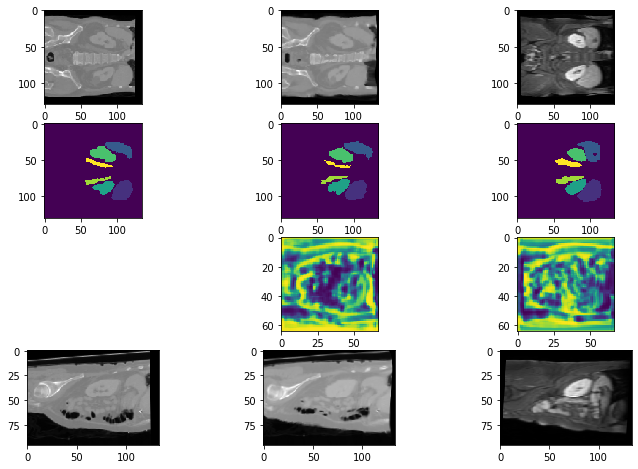

In [16]:
with torch.no_grad():
    seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                   grid_km1_tmp + id_grid,
                                                   mode='nearest',
                                                   padding_mode='border')
    
    print('before: ',dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8),dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8).mean())
    print('after: ',dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8),dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8).mean())
    
    
    img_mov_warp = torch.nn.functional.grid_sample(img_mov_t.cuda(), 
                                                   grid_km1_tmp + id_grid,
                                                   #mode='bilinear',
                                                   padding_mode='border')
    
    print(fix.size())
    
    plt.figure(figsize=(12,8))
    plt_sl = 35
    plt_slice = 30
    plt_chan = 8
    plt.subplot(4,3,1)
    plt.imshow(img_mov_t.cpu()[0,0,:,plt_sl,:],'gray')
    plt.subplot(4,3,2)
    plt.imshow(img_mov_warp.cpu()[0,0,:,plt_sl,:],'gray')
    plt.subplot(4,3,3)
    plt.imshow(img_fix_t.cpu()[0,0,:,plt_sl,:],'gray')
    plt.subplot(4,3,4)
    plt.imshow(seg_mov_t.cpu()[0,0,:,plt_sl,:])
    plt.subplot(4,3,5)
    plt.imshow(seg_mov_warp.cpu()[0,0,:,plt_sl,:])
    plt.subplot(4,3,6)
    plt.imshow(seg_fix_t.cpu()[0,0,:,plt_sl,:])
    plt.subplot(4,3,8)
    plt.imshow(M_km1.cpu()[0,plt_chan,:,plt_slice,:])
    plt.subplot(4,3,9)
    plt.imshow(fix.cpu()[0,plt_chan,:,plt_slice,:])
    plt.subplot(4,3,10)
    plt.imshow(img_mov_t.cpu()[0,0,40,:,:],'gray')
    plt.subplot(4,3,11)
    plt.imshow(img_mov_warp.cpu()[0,0,40,:,:],'gray')
    plt.subplot(4,3,12)
    plt.imshow(img_fix_t.cpu()[0,0,40,:,:],'gray')

1 / 25
CT Pat:  2  :: MR Pat:  1
2 / 25
CT Pat:  17  :: MR Pat:  19
3 / 25
CT Pat:  13  :: MR Pat:  1
4 / 25
CT Pat:  17  :: MR Pat:  1
5 / 25
CT Pat:  19  :: MR Pat:  1
6 / 25
CT Pat:  12  :: MR Pat:  14
7 / 25
CT Pat:  12  :: MR Pat:  6
8 / 25
CT Pat:  13  :: MR Pat:  14
9 / 25
CT Pat:  12  :: MR Pat:  15
10 / 25
CT Pat:  19  :: MR Pat:  12
11 / 25
CT Pat:  12  :: MR Pat:  12
12 / 25
CT Pat:  12  :: MR Pat:  1
13 / 25
CT Pat:  3  :: MR Pat:  14
14 / 25
CT Pat:  2  :: MR Pat:  12
15 / 25
CT Pat:  3  :: MR Pat:  6
16 / 25
CT Pat:  13  :: MR Pat:  12
17 / 25
CT Pat:  13  :: MR Pat:  15
18 / 25
CT Pat:  13  :: MR Pat:  6
19 / 25
CT Pat:  19  :: MR Pat:  14
20 / 25
CT Pat:  3  :: MR Pat:  15
21 / 25
CT Pat:  2  :: MR Pat:  14
22 / 25
CT Pat:  13  :: MR Pat:  19
23 / 25
CT Pat:  2  :: MR Pat:  19
24 / 25
CT Pat:  17  :: MR Pat:  6
25 / 25
CT Pat:  3  :: MR Pat:  12


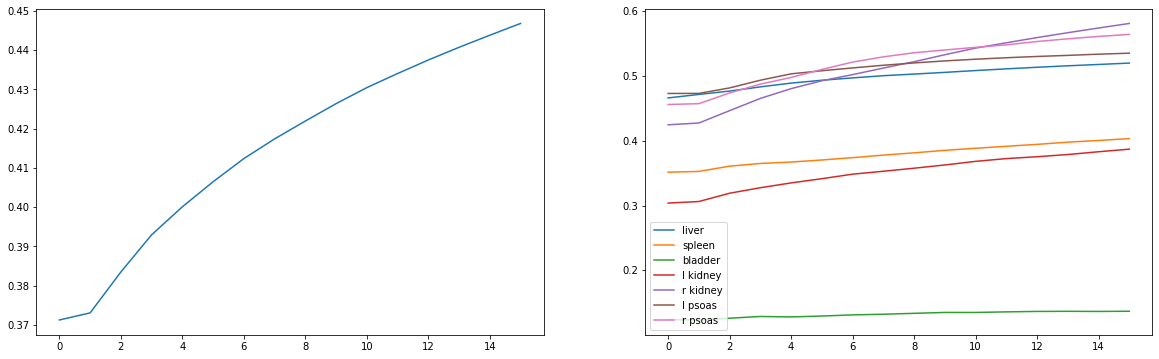

In [17]:
# try to use MIND...
with torch.no_grad():
    dev_nr = 0
    reg_iter = 15#10
    lambda_reg = 10#2.5#25
    solver_iter = 3
    C_out = 12
    sc_val = 0.70
    sub_sc_val = 0.5
    dice_evo_mind = torch.zeros(nr_test_pairs,reg_iter+1,7)
    
    if flag_all:
        for tpdx in range(nr_test_pairs):
            print((tpdx+1).__str__()+' / '+nr_test_pairs.__str__())
            # decoupled dimensions
            with torch.cuda.device(dev_nr):
                #img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[tpdx].item(), mr_test_pats[tpdx].item(), sc_val)
                img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[rnd_ct_test[tpdx]].item(), mr_test_pats[rnd_mr_test[tpdx]].item(), 0.70)
                dice_evo_mind[tpdx,0,:] = dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8)
                _,_,Ds,Hs,Ws = torch.nn.functional.interpolate(img_fix_t,scale_factor=sub_sc_val,mode='trilinear').size()

                L = laplace(lambda_reg,Ds,Hs,Ws).cuda()
                L_u = laplace_block(lambda_reg,Ds,Hs,Ws,'u').cuda()
                L_m = laplace_block(lambda_reg,Ds,Hs,Ws,'m').cuda()
                L_l = laplace_block(lambda_reg,Ds,Hs,Ws,'l').cuda()

                u_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
                v_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
                w_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()

                id_grid = torch.nn.functional.affine_grid(torch.eye(3,4).view(1,3,4),(1,1,D,H,W)).cuda()

                avg3d = torch.nn.AvgPool3d(kernel_size=5,padding=2,stride=1)


                for idx in range(reg_iter):

                    # upscale displacement fields
                    with torch.no_grad():
                        grid_up_km1 = torch.cat((w_km1.view(1,Ds,Hs,Ws,1),v_km1.view(1,Ds,Hs,Ws,1),u_km1.view(1,Ds,Hs,Ws,1)),4)
                        grid_up_km1 = avg3d(grid_up_km1.permute(0,4,1,2,3))
                        #grid_up_km1 = grid_up_km1.permute(0,4,1,2,3)
                        grid_up_km1 = torch.nn.functional.interpolate(grid_up_km1, size=(D,H,W)).permute(0,2,3,4,1)

                        M_km1_full = torch.nn.functional.grid_sample(img_mov_t.view(1,1,D,H,W).cuda(), 
                                                                     grid_up_km1 + id_grid,
                                                                     padding_mode='border')


                    # generate feature representation
                    M_km1 = MINDSSC3d(M_km1_full.detach())#,dil=2,patch_rad=2)
                    fix = MINDSSC3d(img_fix_t.cuda().detach())#,dil=2,patch_rad=2)

                    # subsample
                    M_km1 = torch.nn.functional.interpolate(M_km1,scale_factor=sub_sc_val,mode='trilinear')
                    fix = torch.nn.functional.interpolate(fix,scale_factor=sub_sc_val,mode='trilinear')

                    M_km1_dD = d_dD(M_km1)
                    M_km1_dH = d_dH(M_km1)
                    M_km1_dW = d_dW(M_km1)

                    RHS_D = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dD.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,u_km1.view(Ds*Hs*Ws,1))
                    RHS_H = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dH.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,v_km1.view(Ds*Hs*Ws,1))
                    RHS_W = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dW.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,w_km1.view(Ds*Hs*Ws,1))

                    MAT = torch.sparse.FloatTensor(3*Ds*Hs*Ws,3*Ds*Hs*Ws).cuda()

                    M1_DD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dD**2).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_DH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dD*M_km1_dH).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_DW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dD*M_km1_dW).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()

                    M1_HH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dH**2).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_HD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dH*M_km1_dD).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_HW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dH*M_km1_dW).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()

                    M1_WW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dW**2).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_WD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dW*M_km1_dD).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_WH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dW*M_km1_dH).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()


                    MAT = MAT.add(M1_DD).add(L_u)
                    MAT = MAT.add(M1_DH)
                    MAT = MAT.add(M1_DW)

                    MAT = MAT.add(M1_HD)
                    MAT = MAT.add(M1_HH).add(L_m)
                    MAT = MAT.add(M1_HW)

                    MAT = MAT.add(M1_WD)
                    MAT = MAT.add(M1_WH)
                    MAT = MAT.add(M1_WW).add(L_l)

                    RHS = torch.cat((RHS_D, RHS_H, RHS_W),0)

                    wvu = mlg_solver(MAT,RHS,3)

                    w_k = wvu[2*Ds*Hs*Ws:]*(2.0/(Ws-1.0)) 
                    v_k = wvu[Ds*Hs*Ws:2*Ds*Hs*Ws]*(2.0/(Hs-1.0))
                    u_k = wvu[:Ds*Hs*Ws]*(2.0/(Ds-1.0))

                    u_km1_crnt = u_km1 + u_k#*0.25#25
                    v_km1_crnt = v_km1 + v_k#*0.25#25
                    w_km1_crnt = w_km1 + w_k#*0.25#25

                    grid_km1_tmp = torch.cat((w_km1_crnt.view(1,1,Ds,Hs,Ws),
                                              v_km1_crnt.view(1,1,Ds,Hs,Ws),
                                              u_km1_crnt.view(1,1,Ds,Hs,Ws)),1)
                    grid_km1_tmp = avg3d(grid_km1_tmp)
                    grid_km1_tmp = torch.nn.functional.interpolate(grid_km1_tmp, size=(D,H,W),
                                                                   mode='trilinear').permute(0,2,3,4,1)

                    u_km1 = u_km1_crnt.clone().detach()
                    v_km1 = v_km1_crnt.clone().detach()
                    w_km1 = w_km1_crnt.clone().detach()

                    seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                           grid_km1_tmp + id_grid,
                                                           mode='nearest',
                                                           padding_mode='border')
                    dice_evo_mind[tpdx,idx+1,:] = dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8)
                    
                # save warp seg and image
                ct_pat_str = ct_test_pats[rnd_ct_test[tpdx]].item().__str__()
                mr_pat_str = mr_test_pats[rnd_mr_test[tpdx]].item().__str__()
                seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                               grid_km1_tmp + id_grid,
                                                               mode='nearest',
                                                               padding_mode='border')
                data = seg_mov_warp.squeeze().cpu().numpy()
                new_image = nib.Nifti1Image(data, affine=np.eye(4))
                out_str = './hand_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_seg_warp.nii.gz'
                nib.save(new_image,out_str)

                img_mov_warp = torch.nn.functional.grid_sample(img_mov_t.cuda(), 
                                                               grid_km1_tmp + id_grid,
                                                               #mode='bilinear',
                                                               padding_mode='border')
                data = img_mov_warp.squeeze().cpu().numpy()
                new_image = nib.Nifti1Image(data, affine=np.eye(4))
                out_str = './hand_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_img_warp.nii.gz'
                nib.save(new_image,out_str)

                data = img_fix_t.squeeze().cpu().numpy()
                new_image = nib.Nifti1Image(data, affine=np.eye(4))
                out_str = './hand_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_img_fix.nii.gz'
                nib.save(new_image,out_str)

                data = seg_fix_t.squeeze().cpu().numpy()
                new_image = nib.Nifti1Image(data, affine=np.eye(4))
                out_str = './hand_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_seg_fix.nii.gz'
                nib.save(new_image,out_str)

                data = img_mov_t.squeeze().cpu().numpy()
                new_image = nib.Nifti1Image(data, affine=np.eye(4))
                out_str = './hand_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_img_mov.nii.gz'
                nib.save(new_image,out_str)

                data = seg_mov_t.squeeze().cpu().numpy()
                new_image = nib.Nifti1Image(data, affine=np.eye(4))
                out_str = './hand_MIND/'+tpdx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_seg_mov.nii.gz'
                nib.save(new_image,out_str)


    plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.plot(dice_evo_mind.mean(2).mean(0).cpu().numpy())
    plt.subplot(122)
    plt.plot(dice_evo_mind.mean(0).cpu().numpy())
    plt.legend(labels=["liver","spleen","bladder","l kidney","r kidney", "l psoas", "r psoas"])

before:  tensor([0.6758, 0.6241, 0.0000, 0.6948, 0.7423, 0.5189, 0.5185]) tensor(0.5392)
after:  tensor([0.7103, 0.5911, 0.0067, 0.8317, 0.8354, 0.5209, 0.4925]) tensor(0.5698)


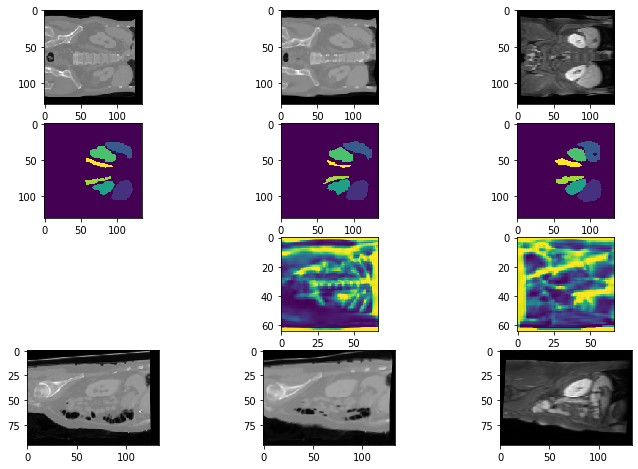

In [18]:
with torch.no_grad():
    if flag_all:
        seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                       grid_km1_tmp + id_grid,
                                                       mode='nearest',
                                                       padding_mode='border')

        print('before: ',dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8),dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8).mean())
        print('after: ',dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8),dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8).mean())


        img_mov_warp = torch.nn.functional.grid_sample(img_mov_t.cuda(), 
                                                       grid_km1_tmp + id_grid,
                                                       #mode='bilinear',
                                                       padding_mode='border')

        plt.figure(figsize=(12,8))
        plt_sl = 35
        plt_slice = 10
        plt_chan = 2
        plt.subplot(4,3,1)
        plt.imshow(img_mov_t.cpu()[0,0,:,plt_sl,:],'gray')
        plt.subplot(4,3,2)
        plt.imshow(img_mov_warp.cpu()[0,0,:,plt_sl,:],'gray')
        plt.subplot(4,3,3)
        plt.imshow(img_fix_t.cpu()[0,0,:,plt_sl,:],'gray')
        plt.subplot(4,3,4)
        plt.imshow(seg_mov_t.cpu()[0,0,:,plt_sl,:])
        plt.subplot(4,3,5)
        plt.imshow(seg_mov_warp.cpu()[0,0,:,plt_sl,:])
        plt.subplot(4,3,6)
        plt.imshow(seg_fix_t.cpu()[0,0,:,plt_sl,:])
        plt.subplot(4,3,8)
        plt.imshow(M_km1.cpu()[0,plt_chan,:,plt_slice,:])
        plt.subplot(4,3,9)
        plt.imshow(fix.cpu()[0,plt_chan,:,plt_slice,:])
        plt.subplot(4,3,10)
        plt.imshow(img_mov_t.cpu()[0,0,40,:,:],'gray')
        plt.subplot(4,3,11)
        plt.imshow(img_mov_warp.cpu()[0,0,40,:,:],'gray')
        plt.subplot(4,3,12)
        plt.imshow(img_fix_t.cpu()[0,0,40,:,:],'gray')

In [19]:
import SimpleITK as sitk

In [69]:
cnt = 0

dice_elastix = torch.zeros(nr_test_pairs,7)
dice_init = torch.zeros(nr_test_pairs,7)

if flag_all:

    for idx in range(nr_test_pairs):

        #img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[idx].item(), mr_test_pats[idx].item(), 1.0)
        img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[rnd_ct_test[idx]].item(), mr_test_pats[rnd_mr_test[idx]].item(), 1.0)
        npa_fix = img_fix_t.squeeze().numpy()
        npa_mov = img_mov_t.squeeze().numpy()

        elastixImageFilter = sitk.ElastixImageFilter()
        elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(npa_fix))
        elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(npa_mov))

        parameterMapVector = sitk.VectorOfParameterMap()
        #parameterMapVector.append(sitk.GetDefaultParameterMap("translation"))
        pmap = sitk.GetDefaultParameterMap("bspline")
        pmap['MaximumNumberOfIterations'] = ['64']
        pmap['FinalGridSpacingInPhysicalUnits'] = ['4']
        parameterMapVector.append(pmap)
        elastixImageFilter.SetParameterMap(parameterMapVector)

        #elastixImageFilter.PrintParameterMap()    

        elastixImageFilter.Execute()
        res = elastixImageFilter.GetResultImage()

        # warp label accordingly
        npa_fix_label = seg_fix_t.squeeze().numpy()
        npa_mov_label = seg_mov_t.squeeze().numpy()

        tp = elastixImageFilter.GetTransformParameterMap()

        tp[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
        ##tp[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]

        #tp[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
        #tp[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
        #tp[2]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]

        resultLabel = sitk.Transformix(sitk.GetImageFromArray(npa_mov_label), tp)
        out_npa_label = sitk.GetArrayViewFromImage(resultLabel)

        dice_init[cnt,:] = dice_coeff(torch.from_numpy(npa_mov_label),torch.from_numpy(npa_fix_label),8)
        dice_elastix[cnt,:] = dice_coeff(torch.from_numpy(out_npa_label),torch.from_numpy(npa_fix_label),8)
        cnt += 1
        
        # save warp seg and image
        ct_pat_str = ct_test_pats[rnd_ct_test[idx]].item().__str__()
        mr_pat_str = mr_test_pats[rnd_mr_test[idx]].item().__str__()
        
        data = out_npa_label
        new_image = nib.Nifti1Image(data, affine=np.eye(4))
        out_str = './simple_elastix/'+idx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_seg_warp.nii.gz'
        nib.save(new_image,out_str)

        data = npa_fix_label
        new_image = nib.Nifti1Image(data, affine=np.eye(4))
        out_str = './simple_elastix/'+idx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_seg_fix.nii.gz'
        nib.save(new_image,out_str)

        data = npa_mov_label
        new_image = nib.Nifti1Image(data, affine=np.eye(4))
        out_str = './simple_elastix/'+idx.__str__()+'_ct'+ct_pat_str+'_mr'+mr_pat_str+'_seg_mov.nii.gz'
        nib.save(new_image,out_str)
        
print('Init:', dice_init.mean())
print('Elastix:', dice_elastix.mean())

CT Pat:  2  :: MR Pat:  1
CT Pat:  17  :: MR Pat:  19
CT Pat:  13  :: MR Pat:  1
CT Pat:  17  :: MR Pat:  1
CT Pat:  19  :: MR Pat:  1
CT Pat:  12  :: MR Pat:  14
CT Pat:  12  :: MR Pat:  6
CT Pat:  13  :: MR Pat:  14
CT Pat:  12  :: MR Pat:  15
CT Pat:  19  :: MR Pat:  12
CT Pat:  12  :: MR Pat:  12
CT Pat:  12  :: MR Pat:  1
CT Pat:  3  :: MR Pat:  14
CT Pat:  2  :: MR Pat:  12
CT Pat:  3  :: MR Pat:  6
CT Pat:  13  :: MR Pat:  12
CT Pat:  13  :: MR Pat:  15
CT Pat:  13  :: MR Pat:  6
CT Pat:  19  :: MR Pat:  14
CT Pat:  3  :: MR Pat:  15
CT Pat:  2  :: MR Pat:  14
CT Pat:  13  :: MR Pat:  19
CT Pat:  2  :: MR Pat:  19
CT Pat:  17  :: MR Pat:  6
CT Pat:  3  :: MR Pat:  12
Init: tensor(0.3715)
Elastix: tensor(0.4081)


tensor(0.4081)
tensor([[6.2490e-01, 4.2539e-01, 7.8851e-02, 1.2939e-02, 2.5184e-01, 2.1403e-01,
         2.2146e-01],
        [9.0716e-02, 0.0000e+00, 3.2557e-01, 3.5104e-02, 3.0086e-01, 5.6515e-01,
         6.1693e-01],
        [5.0045e-01, 4.4489e-01, 0.0000e+00, 6.1139e-03, 4.3449e-01, 3.0485e-01,
         5.5275e-01],
        [4.0934e-01, 1.8029e-01, 5.9082e-02, 0.0000e+00, 3.5764e-01, 7.6000e-02,
         3.1626e-01],
        [4.1674e-01, 2.1835e-01, 1.0090e-01, 0.0000e+00, 3.7649e-01, 2.0131e-01,
         3.3460e-01],
        [1.6728e-01, 3.2109e-01, 4.3985e-01, 1.1483e-01, 1.8775e-01, 5.9224e-01,
         3.6901e-01],
        [4.3861e-01, 2.7984e-01, 0.0000e+00, 4.9348e-01, 6.0742e-01, 6.6629e-01,
         4.5980e-01],
        [4.5868e-01, 6.0060e-01, 6.0566e-03, 7.0229e-02, 3.1493e-01, 5.0771e-01,
         3.4304e-01],
        [6.2296e-01, 5.8482e-01, 0.0000e+00, 5.9285e-01, 7.3539e-01, 5.2092e-01,
         4.3486e-01],
        [3.8362e-01, 3.1774e-01, 1.9188e-01, 1.5864e-01, 4

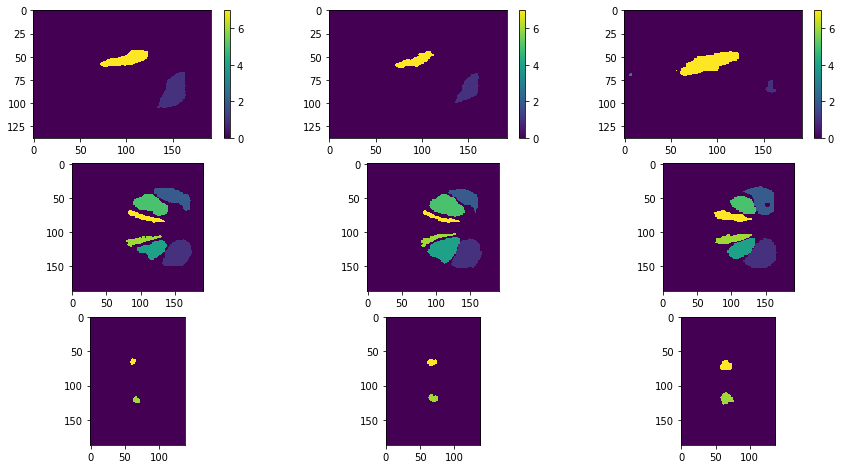

In [21]:
print(dice_elastix.mean().mean())
print(dice_init)
print(dice_elastix)

if flag_all:

    #tp[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    ##tp[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]

    tp[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    #tp[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    #tp[2]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]

    resultLabel = sitk.Transformix(sitk.GetImageFromArray(npa_mov_label), tp)
    out_npa_label = sitk.GetArrayViewFromImage(resultLabel)

    plt.figure(figsize=(15,8))
    plt.subplot(331)
    plt.imshow(npa_mov_label[80,:,:])
    plt.colorbar()
    plt.subplot(332)
    plt.imshow(out_npa_label[80,:,:])
    plt.colorbar()
    plt.subplot(333)
    plt.imshow(npa_fix_label[80,:,:])
    plt.colorbar()
    plt.subplot(334)
    plt.imshow(npa_mov_label[:,50,:])
    plt.subplot(335)
    plt.imshow(out_npa_label[:,50,:])
    plt.subplot(336)
    plt.imshow(npa_fix_label[:,50,:])
    plt.subplot(337)
    plt.imshow(npa_mov_label[:,:,50])
    plt.subplot(338)
    plt.imshow(out_npa_label[:,:,50])
    plt.subplot(339)
    plt.imshow(npa_fix_label[:,:,50])

In [22]:
print('INIT')
#print(dice_init)
print(dice_init.mean(1))
print(dice_init.mean(1).mean())
print(' ')
print('NET_pre')
#print(dice_evo_net_pre[:,-1,:])
print(dice_evo_net_pre[:,-1,:].mean(1))
print(dice_evo_net_pre[:,-1,:].mean(1).mean())
print(' ')
print('NET_tune')
#print(dice_evo_net_tune[:,-1,:])
print(dice_evo_net_tune[:,-1,:].mean(1))
print(dice_evo_net_tune[:,-1,:].mean(1).mean())
print(' ')
print('MIND')
#print(dice_evo_mind[:,-1,:])
print(dice_evo_mind[:,-1,:].mean(1))
print(dice_evo_mind[:,-1,:].mean(1).mean())
print(' ')
print('Elastix')
#print(dice_elastix)
print(dice_elastix.mean(1))
print(dice_elastix.mean(1).mean())

INIT
tensor([0.2613, 0.2763, 0.3205, 0.1998, 0.2355, 0.3132, 0.4208, 0.3287, 0.4988,
        0.3581, 0.5676, 0.3332, 0.3506, 0.4226, 0.4842, 0.3487, 0.3433, 0.3370,
        0.3666, 0.4979, 0.3759, 0.2690, 0.5682, 0.2722, 0.5369])
tensor(0.3715)
 
NET_pre
tensor([0.2993, 0.3144, 0.3712, 0.2182, 0.2691, 0.3458, 0.4771, 0.3771, 0.5731,
        0.4881, 0.6470, 0.3851, 0.4358, 0.4814, 0.5340, 0.4637, 0.4629, 0.3859,
        0.4146, 0.5253, 0.4100, 0.3235, 0.6722, 0.3490, 0.5597])
tensor(0.4313)
 
NET_tune
tensor([0.3407, 0.3348, 0.4110, 0.2437, 0.3128, 0.3331, 0.5228, 0.4010, 0.5778,
        0.5348, 0.6380, 0.4718, 0.4557, 0.5157, 0.5774, 0.4646, 0.4736, 0.3750,
        0.4185, 0.5423, 0.4335, 0.3581, 0.6972, 0.4005, 0.5735])
tensor(0.4563)
 
MIND
tensor([0.3223, 0.3276, 0.3635, 0.2385, 0.3101, 0.3598, 0.5040, 0.3955, 0.5804,
        0.5254, 0.6524, 0.4059, 0.4497, 0.5031, 0.5548, 0.4702, 0.4637, 0.3934,
        0.4332, 0.5255, 0.4544, 0.3467, 0.6662, 0.3545, 0.5698])
tensor(0.4468)
 
Elast

In [23]:
# without bladder!

print('INIT')
#print(dice_init)
print(dice_init[:,torch.LongTensor([0,1,2,4,5,6])].mean(1))
print(dice_init[:,torch.LongTensor([0,1,2,4,5,6])].mean(1).mean())
print(' ')
print('NET_pre')
#print(dice_evo_net_pre[:,-1,:])
print(dice_evo_net_pre[:,-1,torch.LongTensor([0,1,2,4,5,6])].mean(1))
print(dice_evo_net_pre[:,-1,torch.LongTensor([0,1,2,4,5,6])].mean(1).mean())
print(' ')
print('NET_tune')
#print(dice_evo_net_tune[:,-1,:])
print(dice_evo_net_tune[:,-1,torch.LongTensor([0,1,2,4,5,6])].mean(1))
print(dice_evo_net_tune[:,-1,torch.LongTensor([0,1,2,4,5,6])].mean(1).mean())
print(' ')
print('MIND')
#print(dice_evo_mind[:,-1,:])
print(dice_evo_mind[:,-1,torch.LongTensor([0,1,2,4,5,6])].mean(1))
print(dice_evo_mind[:,-1,torch.LongTensor([0,1,2,4,5,6])].mean(1).mean())
print(' ')
print('Elastix')
#print(dice_elastix)
print(dice_elastix[:,torch.LongTensor([0,1,2,4,5,6])].mean(1))
print(dice_elastix[:,torch.LongTensor([0,1,2,4,5,6])].mean(1).mean())

INIT
tensor([0.3027, 0.3165, 0.3729, 0.2331, 0.2747, 0.3462, 0.4087, 0.3718, 0.4832,
        0.3913, 0.5415, 0.3860, 0.3968, 0.4210, 0.4464, 0.3114, 0.3152, 0.3095,
        0.4277, 0.4744, 0.4168, 0.2481, 0.5899, 0.2762, 0.5110])
tensor(0.3829)
 
NET_pre
tensor([0.3470, 0.3548, 0.4299, 0.2546, 0.3140, 0.3845, 0.4481, 0.4249, 0.5544,
        0.5257, 0.6199, 0.4452, 0.4881, 0.4804, 0.4876, 0.4170, 0.4126, 0.3423,
        0.4837, 0.4774, 0.4590, 0.2935, 0.6885, 0.3256, 0.5146])
tensor(0.4389)
 
NET_tune
tensor([0.3955, 0.3762, 0.4681, 0.2843, 0.3650, 0.3636, 0.4954, 0.4391, 0.5535,
        0.5742, 0.6066, 0.5432, 0.5048, 0.5116, 0.5359, 0.4196, 0.4239, 0.3455,
        0.4883, 0.4956, 0.4828, 0.3210, 0.7060, 0.3711, 0.5310])
tensor(0.4641)
 
MIND
tensor([0.3746, 0.3664, 0.4163, 0.2783, 0.3618, 0.4044, 0.4811, 0.4428, 0.5565,
        0.5693, 0.6264, 0.4697, 0.5084, 0.5036, 0.5092, 0.4199, 0.4132, 0.3518,
        0.5054, 0.4791, 0.5154, 0.3191, 0.6828, 0.3384, 0.5262])
tensor(0.4568)
 
Elast

In [86]:
import numpy as np
from scipy.ndimage import morphology

def surfd(input1, input2, sampling=3, connectivity=1):
    '''
    Compute surface distances between two binary images.
    '''
    #The two inputs are checked for their size and made binary. Any value greater than zero is made 1
    input1_bin = np.atleast_1d(input1.astype(np.bool))
    input2_bin = np.atleast_1d(input2.astype(np.bool))

    conn = morphology.generate_binary_structure(input1_bin.ndim, connectivity)

    S = input1_bin ^ morphology.binary_erosion(input1_bin, conn)
    Sprime = input2_bin ^ morphology.binary_erosion(input2_bin, conn)

    dta = morphology.distance_transform_edt(~S, sampling)
    dtb = morphology.distance_transform_edt(~Sprime, sampling)

    sds = np.concatenate([np.ravel(dta[Sprime != 0]), np.ravel(dtb[S != 0])])

    return sds

def compute_assd(input, target, n_classes, spacing=np.array([1.0, 1.0, 1.0])):
    '''Compute average symmetric surface distance '''
    #with warnings.catch_warnings():
        #warnings.simplefilter("ignore", category=RuntimeWarning)
    assd = np.zeros(n_classes)
    for label_num in range(0, n_classes):
        if label_num != 0 and label_num != 3: 
            assd[label_num] = surfd(input == label_num, target == label_num, spacing, 1).mean()
        else:
            assd[label_num] = np.nan

    return assd

def compute_hd95(input, target, n_classes, spacing=np.array([1.0, 1.0, 1.0])):
    '''Compute average symmetric surface distance '''
    #with warnings.catch_warnings():
        #warnings.simplefilter("ignore", category=RuntimeWarning)
    hd95 = np.zeros(n_classes)
    for label_num in range(0, n_classes):
        if label_num != 0 and label_num != 3: 
            tmp = surfd(input == label_num, target == label_num, spacing, 1)
            #print(tmp.shape)
            tmp = np.sort(tmp)
            idx = int(0.95*tmp.shape[0])
            #print(idx)
            hd95[label_num] = tmp[idx]
        else:
            hd95[label_num] = np.nan

    return hd95

In [79]:
seg_fix = nib.load('./finetuned_MIND/0_ct2_mr1_seg_fix.nii.gz').get_data()
seg_warp = nib.load('./finetuned_MIND/0_ct2_mr1_seg_warp.nii.gz').get_data()
seg_mov = nib.load('./finetuned_MIND/0_ct2_mr1_seg_mov.nii.gz').get_data()

print(seg_mov.shape)



(130, 96, 134)


In [57]:
init_assd=compute_assd(seg_mov,seg_fix,8,np.array([2.0,2.0,2.0]))
warp_assd=compute_assd(seg_warp,seg_fix,8,np.array([2.0,2.0,2.0]))
init_assd=init_assd[~np.isnan(init_assd)]# x = x[~numpy.isnan(x)]
warp_assd=warp_assd[~np.isnan(warp_assd)]
print(init_assd)
print(warp_assd)

[ 8.78825392 10.67273106 21.90044841 11.7240547   8.48723815  6.72631459]
[ 9.60618503  8.95455313 21.9576887  10.44129557  5.38343346  5.34202775]


In [89]:
init_hd95=compute_hd95(seg_mov,seg_fix,8,np.array([2.0,2.0,2.0]))
warp_hd95=compute_hd95(seg_warp,seg_fix,8,np.array([2.0,2.0,2.0]))
init_hd95=init_hd95[~np.isnan(init_hd95)]# x = x[~numpy.isnan(x)]
warp_hd95=warp_hd95[~np.isnan(warp_hd95)]
print(init_hd95)
print(warp_hd95)

# ASSD INIT
init_assd_all = np.zeros((25,6))
init_hd95_all = np.zeros((25,6))
for idx in range(25):
    ct_idx = ct_test_pats[rnd_ct_test[idx]].item().__str__()
    mr_idx = mr_test_pats[rnd_mr_test[idx]].item().__str__()
    
    pair_str = idx.__str__()+'_ct'+ct_idx+'_mr'+mr_idx+'_seg_'
    seg_fix = nib.load('./finetuned_MIND/'+pair_str+'fix.nii.gz').get_data()
    seg_mov = nib.load('./finetuned_MIND/'+pair_str+'mov.nii.gz').get_data()
    init_assd=compute_assd(seg_mov,seg_fix,8,np.array([2.0,2.0,2.0])*(1.0/0.7))
    init_assd=init_assd[~np.isnan(init_assd)]# x = x[~numpy.isnan(x)]
    init_hd95=compute_hd95(seg_mov,seg_fix,8,np.array([2.0,2.0,2.0])*(1.0/0.7))
    init_hd95=init_hd95[~np.isnan(init_hd95)]# x = x[~numpy.isnan(x)]
    
    init_assd_all[idx,:] = init_assd
    init_hd95_all[idx,:] = init_hd95
    
print(init_assd_all.mean(0))
print(init_hd95_all.mean(0))

[21.59654611 19.10988201 23.05792807 10.17626296  7.05074295  6.76588423]
[60.8953799  49.08771554 46.54390102 23.88404872 19.89344711 18.05226632]


In [90]:
pre_assd_all = np.zeros((25,6))
pre_hd95_all = np.zeros((25,6))
for idx in range(25):
    ct_idx = ct_test_pats[rnd_ct_test[idx]].item().__str__()
    mr_idx = mr_test_pats[rnd_mr_test[idx]].item().__str__()
    
    pair_str = idx.__str__()+'_ct'+ct_idx+'_mr'+mr_idx+'_seg_'
    seg_fix = nib.load('./pretrained_MIND/'+pair_str+'fix.nii.gz').get_data()
    seg_warp = nib.load('./pretrained_MIND/'+pair_str+'warp.nii.gz').get_data()

    warp_assd=compute_assd(seg_warp,seg_fix,8,np.array([2.0,2.0,2.0])*(1.0/0.7))
    warp_assd=warp_assd[~np.isnan(warp_assd)]
    warp_hd95=compute_hd95(seg_warp,seg_fix,8,np.array([2.0,2.0,2.0])*(1.0/0.7))
    warp_hd95=warp_hd95[~np.isnan(warp_hd95)]
    
    pre_assd_all[idx,:] = warp_assd
    pre_hd95_all[idx,:] = warp_hd95
    
print(pre_assd_all.mean(0))
print(pre_hd95_all.mean(0))

[20.09338858 17.93398695 21.48721213  7.56193477  6.65335668  5.87200087]
[58.96635177 48.66489932 43.72231026 20.94674402 20.8225422  16.51638399]


In [91]:
tune_assd_all = np.zeros((25,6))
tune_hd95_all = np.zeros((25,6))
for idx in range(25):
    ct_idx = ct_test_pats[rnd_ct_test[idx]].item().__str__()
    mr_idx = mr_test_pats[rnd_mr_test[idx]].item().__str__()
    
    pair_str = idx.__str__()+'_ct'+ct_idx+'_mr'+mr_idx+'_seg_'
    seg_fix = nib.load('./finetuned_MIND/'+pair_str+'fix.nii.gz').get_data()
    seg_warp = nib.load('./finetuned_MIND/'+pair_str+'warp.nii.gz').get_data()

    warp_assd=compute_assd(seg_warp,seg_fix,8,np.array([2.0,2.0,2.0])*(1.0/0.7))
    warp_assd=warp_assd[~np.isnan(warp_assd)]
    warp_hd95=compute_hd95(seg_warp,seg_fix,8,np.array([2.0,2.0,2.0])*(1.0/0.7))
    warp_hd95=warp_hd95[~np.isnan(warp_hd95)]
    
    tune_assd_all[idx,:] = warp_assd
    tune_hd95_all[idx,:] = warp_hd95
    
print(tune_assd_all.mean(0))
print(tune_hd95_all.mean(0))

[18.93251516 16.47416251 20.20830932  7.32601731  6.23620948  5.66592945]
[57.84538182 46.53770728 42.41740448 20.63049854 19.71282184 15.95615417]


In [94]:
ela_assd_all = np.zeros((25,6))
ela_hd95_all = np.zeros((25,6))
for idx in range(25):
    ct_idx = ct_test_pats[rnd_ct_test[idx]].item().__str__()
    mr_idx = mr_test_pats[rnd_mr_test[idx]].item().__str__()
    
    pair_str = idx.__str__()+'_ct'+ct_idx+'_mr'+mr_idx+'_seg_'
    seg_fix = nib.load('./simple_elastix/'+pair_str+'fix.nii.gz').get_data()
    seg_warp = nib.load('./simple_elastix/'+pair_str+'warp.nii.gz').get_data()

    warp_assd=compute_assd(seg_warp,seg_fix,8,np.array([2.0,2.0,2.0]))
    warp_assd=warp_assd[~np.isnan(warp_assd)]
    warp_hd95=compute_hd95(seg_warp,seg_fix,8,np.array([2.0,2.0,2.0]))
    warp_hd95=warp_hd95[~np.isnan(warp_hd95)]
    
    ela_assd_all[idx,:] = warp_assd
    ela_hd95_all[idx,:] = warp_hd95
    
print(ela_assd_all.mean(0))
print(ela_hd95_all.mean(0))

[18.95348505 16.09468301 22.01914835  9.83242867  7.24993697  6.94250561]
[60.01752255 46.39139692 47.22423422 25.19407895 21.10015121 18.83534349]


In [93]:
vox_assd_all = np.zeros((25,6))
vox_hd95_all = np.zeros((25,6))
for idx in range(25):
    ct_idx = ct_test_pats[rnd_ct_test[idx]].item().__str__()
    mr_idx = mr_test_pats[rnd_mr_test[idx]].item().__str__()
    
    pair_str = idx.__str__()+'_ct'+ct_idx+'_mr'+mr_idx+'_seg_'
    seg_fix = nib.load('./voxelmorph/'+pair_str+'fix.nii.gz').get_data()
    seg_warp = nib.load('./voxelmorph/'+pair_str+'warp.nii.gz').get_data()

    warp_assd=compute_assd(seg_warp,seg_fix,8,np.array([2.0,2.0,2.0])*(1.0/0.7))
    warp_assd=warp_assd[~np.isnan(warp_assd)]
    warp_hd95=compute_hd95(seg_warp,seg_fix,8,np.array([2.0,2.0,2.0])*(1.0/0.7))
    warp_hd95=warp_hd95[~np.isnan(warp_hd95)]
    
    vox_assd_all[idx,:] = warp_assd
    vox_hd95_all[idx,:] = warp_hd95
    
print(vox_assd_all.mean(0))
print(vox_hd95_all.mean(0))

[17.34695765 15.33214765 21.0268747   8.62691443  7.34333121  6.32987241]
[58.81592226 43.55396419 46.69917376 22.92874333 21.10387934 17.71171794]


In [95]:
print('::::: ASSD')
print('Init:',init_assd_all.mean(0),init_assd_all.mean(0).mean())
print('Ela :',ela_assd_all.mean(0),ela_assd_all.mean(0).mean())
print('Vox :',vox_assd_all.mean(0),vox_assd_all.mean(0).mean())
print('Pre :',pre_assd_all.mean(0),pre_assd_all.mean(0).mean())
print('Tune:',tune_assd_all.mean(0),tune_assd_all.mean(0).mean())

print('::::: HD95')
print('Init:',init_hd95_all.mean(0),init_hd95_all.mean(0).mean())
print('Ela :',ela_hd95_all.mean(0),ela_hd95_all.mean(0).mean())
print('Vox :',vox_hd95_all.mean(0),vox_hd95_all.mean(0).mean())
print('Pre :',pre_hd95_all.mean(0),pre_hd95_all.mean(0).mean())
print('Tune:',tune_hd95_all.mean(0),tune_hd95_all.mean(0).mean())

np.savetxt( './assd_init.txt', init_assd_all, delimiter='\t', fmt='%5f')
np.savetxt( './ela_assd.txt', ela_assd_all, delimiter='\t', fmt='%5f')
np.savetxt( './pre_assd.txt', pre_assd_all, delimiter='\t', fmt='%5f')
np.savetxt( './tune_assd.txt', tune_assd_all, delimiter='\t', fmt='%5f')
np.savetxt( './vox_assd.txt', vox_assd_all, delimiter='\t', fmt='%5f')

np.savetxt( './hd95_init.txt', init_hd95_all, delimiter='\t', fmt='%5f')
np.savetxt( './ela_hd95.txt', ela_hd95_all, delimiter='\t', fmt='%5f')
np.savetxt( './pre_hd95.txt', pre_hd95_all, delimiter='\t', fmt='%5f')
np.savetxt( './tune_hd95.txt', tune_hd95_all, delimiter='\t', fmt='%5f')
np.savetxt( './vox_hd95.txt', vox_hd95_all, delimiter='\t', fmt='%5f')

::::: ASSD
Init: [21.59654611 19.10988201 23.05792807 10.17626296  7.05074295  6.76588423] 14.626207723992408
Ela : [18.95348505 16.09468301 22.01914835  9.83242867  7.24993697  6.94250561] 13.51536461048421
Vox : [17.34695765 15.33214765 21.0268747   8.62691443  7.34333121  6.32987241] 12.66768300909694
Pre : [20.09338858 17.93398695 21.48721213  7.56193477  6.65335668  5.87200087] 13.266979997065818
Tune: [18.93251516 16.47416251 20.20830932  7.32601731  6.23620948  5.66592945] 12.473857204853852
::::: HD95
Init: [60.8953799  49.08771554 46.54390102 23.88404872 19.89344711 18.05226632] 36.39279310190221
Ela : [60.01752255 46.39139692 47.22423422 25.19407895 21.10015121 18.83534349] 36.460454558217634
Vox : [58.81592226 43.55396419 46.69917376 22.92874333 21.10387934 17.71171794] 35.135566804631765
Pre : [58.96635177 48.66489932 43.72231026 20.94674402 20.8225422  16.51638399] 34.93987192759192
Tune: [57.84538182 46.53770728 42.41740448 20.63049854 19.71282184 15.95615417] 33.84999468